## Setup

In [ ]:
import cv2  # OpenCV para carregar a imagem
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from typing import List, Callable
from PIL import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.image as mpimg
import sys
import os

module_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(module_path)

import Interface as mi
import filter_toolbox
from CosSimilarityPipeline import CosSimilarityPipeline as model_pipeline

In [3]:
filter_intensity = 0.2

## T1

In [4]:
img_path = r"data\sdss\sdss_image_180.451206348309_-0.324013595202261.jpg"

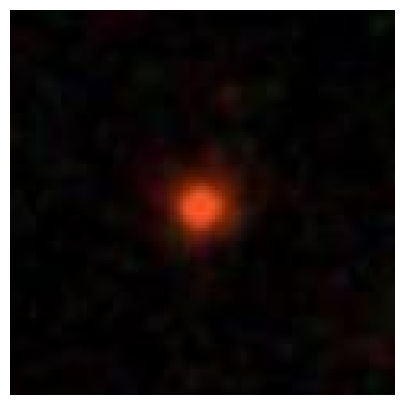

In [5]:
# Carregar a imagem
img = mpimg.imread(img_path)

# Criar uma nova figura
plt.figure(figsize=(5, 5))  # O argumento figsize define o tamanho da figura

# Exibir a imagem
plt.imshow(img)

# Remover os eixos
plt.axis('off')

# Mostrar a figura
plt.show()

In [6]:
def generate_kernel_params(shape: int) -> List[mi.KernelParam]:
        """
        Gera uma lista de parâmetros de kernel com combinações de `size` e `sigma` 
        que respeitam a equação do projetor gama.
        
        Parâmetros:
        - max_size: tamanho máximo permitido para o kernel baseado no tamanho da imagem.

        Retorna:
        - Uma lista de `mi.KernelParam` com todas as combinações válidas de `size` e `sigma`.
        """
        kernel_params = []
        M, N = shape
        for K_s in range(3, min(M, N)):# Tamanhos de kernel ímpares
            for sigma in range(1, int(2 * K_s + 3)):
                kernel_params.append(mi.KernelParam(size=K_s, sigma=sigma))
        return kernel_params

In [7]:
kernel_param = generate_kernel_params(img.shape[0:2])

kernel_param

[KernelParam(size=3, sigma=1.0),
 KernelParam(size=3, sigma=2.0),
 KernelParam(size=3, sigma=3.0),
 KernelParam(size=3, sigma=4.0),
 KernelParam(size=3, sigma=5.0),
 KernelParam(size=3, sigma=6.0),
 KernelParam(size=3, sigma=7.0),
 KernelParam(size=3, sigma=8.0),
 KernelParam(size=4, sigma=1.0),
 KernelParam(size=4, sigma=2.0),
 KernelParam(size=4, sigma=3.0),
 KernelParam(size=4, sigma=4.0),
 KernelParam(size=4, sigma=5.0),
 KernelParam(size=4, sigma=6.0),
 KernelParam(size=4, sigma=7.0),
 KernelParam(size=4, sigma=8.0),
 KernelParam(size=4, sigma=9.0),
 KernelParam(size=4, sigma=10.0),
 KernelParam(size=5, sigma=1.0),
 KernelParam(size=5, sigma=2.0),
 KernelParam(size=5, sigma=3.0),
 KernelParam(size=5, sigma=4.0),
 KernelParam(size=5, sigma=5.0),
 KernelParam(size=5, sigma=6.0),
 KernelParam(size=5, sigma=7.0),
 KernelParam(size=5, sigma=8.0),
 KernelParam(size=5, sigma=9.0),
 KernelParam(size=5, sigma=10.0),
 KernelParam(size=5, sigma=11.0),
 KernelParam(size=5, sigma=12.0),
 Kerne

In [8]:
kernel_param[-1]

KernelParam(size=119, sigma=240.0)

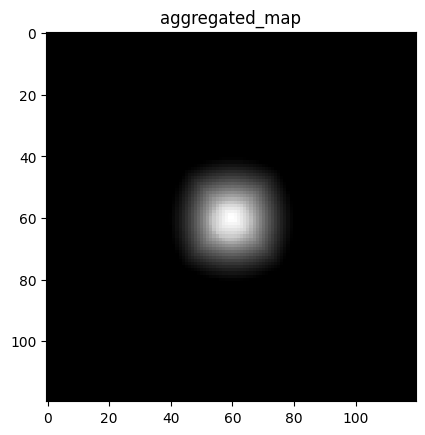

In [9]:
input_data = mi.PipelineInput(
    img_path = img_path,
    filter_intensity=filter_intensity,
    kernel_param=kernel_param,
    agg_type=np.sum
)
model = model_pipeline(is_debug=False)
agg=model.run(input_data=input_data)

#8m 41s

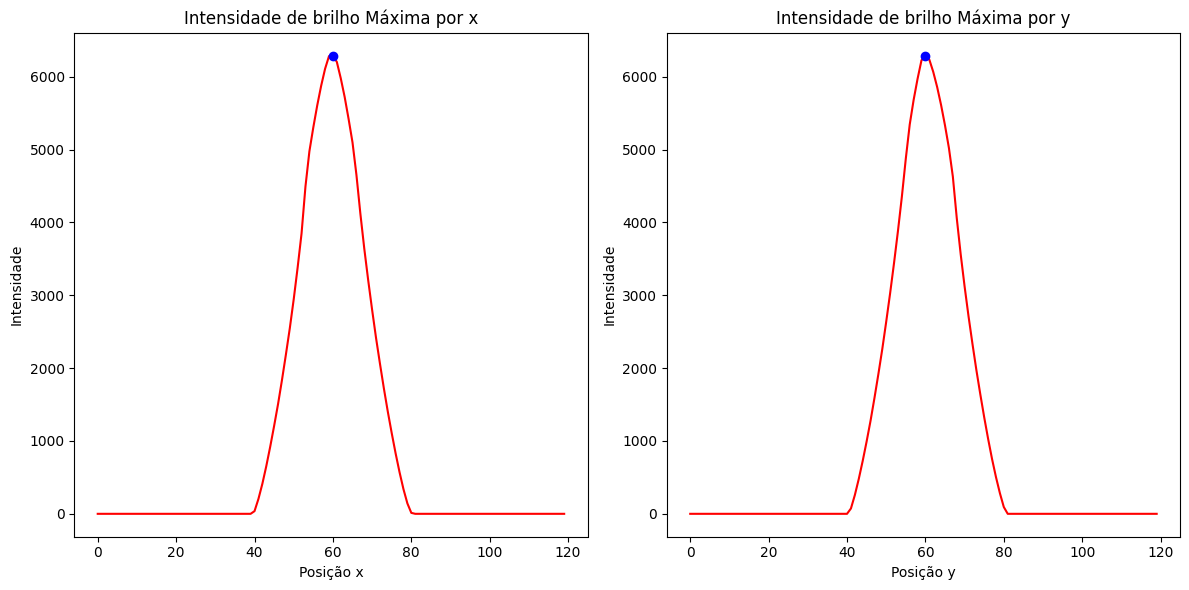

In [10]:
image = cv2.imread(img_path)

# 
resultado_final = agg.map

# Obter a intensidade ao longo das dimensões x e y
intensity = np.stack(resultado_final, axis=0)

# Encontrar o valor máximo por linha (eixo y) e por coluna (eixo x)
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y (colunas)
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x (linhas)

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x e y
prominence_x = 0.15 * max(max_by_x)  # Prominência de 15% do valor máximo
prominence_y = 0.15 * max(max_by_y)  # Prominência de 15% do valor máximo

peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x, height=0.55 * max(max_by_x))
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y, height=0.55 * max(max_by_y))

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()

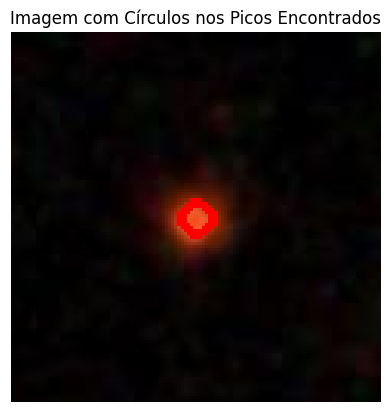

In [11]:
# Encontrar os pares de coordenadas onde há picos nos dois eixos
# Percorrer o mapa de intensidade para verificar onde os picos de x e y coincidem
peak_coords = [(x, y) for y in peaks_y for x in peaks_x if intensity[y, x] >= 0.55 * intensity.max()]

# Desenhar círculos nas coordenadas dos picos encontrados
for (x, y) in peak_coords:
    center = (int(x), int(y))  # Coordenadas (x, y)
    radius = 5  # Raio do círculo
    color = (0, 0, 255)  # Cor (vermelho em BGR)
    thickness = 2  # Espessura da borda
    cv2.circle(image, center, radius, color, thickness)

# Mostrar a imagem com os círculos
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Imagem com Círculos nos Picos Encontrados')
plt.axis('off')
plt.show()


In [12]:
# Encontrar os pares de coordenadas onde há picos nos dois eixos
# Percorrer o mapa de intensidade para verificar onde os picos de x e y coincidem
peak_coords = [(x, y) for y in peaks_y for x in peaks_x if intensity[y, x] >= 0.55 * intensity.max()]

peak_coords

[(60, 60)]

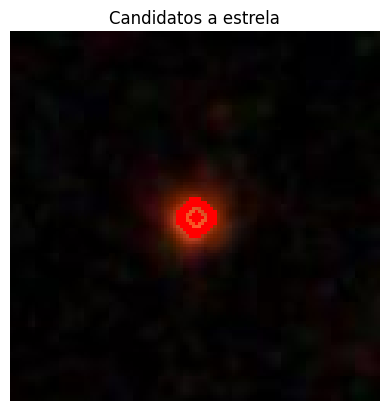

In [13]:
# Desenhar pontos nas coordenadas dos picos encontrados
for (x, y) in peak_coords:
    center = (int(x), int(y))  # Coordenadas (x, y)
    color = (0, 0, 255)  # Cor (vermelho em BGR)
    thickness = -1  # Espessura do ponto, negativo preenche o marcador
    cv2.circle(image, center, 2, color, thickness)  # Desenha um ponto com raio 2

# Mostrar a imagem com os pontos
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Candidatos a estrela')
plt.axis('off')
plt.show()